# **Lecture: K - Means Clustering** 
The search for the clusters!

_Problem:_ You are given a set of data that is unlabeled, but you believe that it can be sorted into groups. You believe that objects that are close together are related. You also know that the data in the given data set is measurements in `cm` of four different parts of some flowers from a field. 
The following notebook will give us some of the tools to try and determine how the data should be clustered together.  

Modules:
- Numpy
- Pandas
- Matplotlib

Variables:
- `l = 0`  Set a counter for the number of clusters. 
- `F = 2`  Number of features.
- `K` Current number of clusters. This will loop from 1 to 10.
- `N = 3` Number of clusters for plotting (late notebook).


---

## **Read In The Data**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Read in the data as a Dataframe and label each Series with a name. (.sample(frac=1) shuffles the data)
all_data = pd.read_csv('~/Files/Data/iris_KNN.csv', names = ["Feature_1","Feature_2","Feature_3","Feature_4", "Group"], delimiter=',')
all_data = all_data.iloc[1:]

In this next cell we will drop the Group column. Since we "don't" know how many clusters we should have this gives us a good starting place. 

In [2]:
all_data = all_data.iloc[1:].drop(columns=["Group"]) # Print some of the data. (head is the start of the data)

In [4]:
all_data= all_data.astype(float)
all_data

,Feature_1,Feature_2,Feature_3,Feature_4
1.0,4.7,3.2,1.3,0.2
2.0,4.6,3.1,1.5,0.2
3.0,5.0,3.6,1.4,0.2
4.0,5.4,3.9,1.7,0.4
5.0,4.6,3.4,1.4,0.3
...,...,...,...,...
144.0,6.7,3.0,5.2,2.3
145.0,6.3,2.5,5.0,1.9
146.0,6.5,3.0,5.2,2.0
147.0,6.2,3.4,5.4,2.3


In [5]:
# Make a Series for two of the features for visulization.  
F1 = all_data["Feature_1"]
F2 = all_data["Feature_2"]

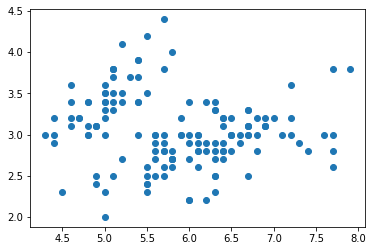

In [6]:
# Plot the data with respect to the first two features.
plt.scatter(F1, F2)
plt.show()

In [8]:
# This definition will make the starting centroids for each of cluster counts.
def gen_centroids(k,f):
    return np.array(all_data.sample(frac=1).iloc[:k,:f])

---
---

## **Code Block Breakdown**
---
In this first bit will will establish some of the variables that we will need, as well as some lists that we will fill as the loops run.
```Python
l = 0 # Set a counter for the number of clusters. 
F = 2 # Number of features.
variance = [] # An empty list to collect the variance. 
Centroids_Per_Cluster = [] # An empty list to collect the centroids for each cluster setting.
```

---
This is the start of the `for` loop that will check cluster sizes. This will run over all the possible amounts of clusters. (really it is 1 through 10). Since we are not yet sure how many classes of objects we will have, letting it check a few will help use to get a better idea. 

This section of code is also where we will call the above definition, to generate the starting centroids. 

``` Python
# Loop over all the possible number of clusters. This is hard coded to run from 1 to 10.  
for K in range(1,10):

    centroids = gen_centroids(K,F) # Get the starting set of centroids. 

    features = np.array(all_data.iloc[:,:F]) # Features from all the data. We can 1 through 4. (2 for 2D scatter plot)  

    convergence_check = 1 # Dummy variable to start the while loop. 

```

---

This `while` loop is the main loop of the algorithm. We want this loop to run until the centroids stop moving at each check. The `convergence_check` is the distance between two consecutive iterations of centroids. Once this distance is close, we can say that the points have converged and move onto the next cluster size.

```Python
    # Main convergence loop. This will run until two consecutive iterations of centroids are close toegther. 
    while convergence_check > 0:
        
        cluster_index = [] # Empty list to collect the cluster index value for each of the points. 
        
```

---

This is where the main mathematics of the algorithm is. This `for` loop checks the distance that each of the data points is from the different clusters. It then selects the closest cluster, and appends the `cluster_index` for that cluster. The distance is measured using,

$$ \sqrt{\sum{(\mathbf{\bar{x}}_i - \mathbf{x}}) ^2} $$

for where each $\mathbf{\bar{x}}_i$ is one of the centroids and each $\mathbf{x}$ is a data point in of our data.

```Python

        # This will loop over all the data, checking the Euclidean distance to the other centroids.
        # This loop also finds the closest centroid for a data point, and gives it that cluster index.
        for d in features:
            current_centroids = centroids # Set the current centroids to the last ones. 
            
            D = []  # List for the data features for each datum.
            for s in range(K): # Loop over the number of clusters. 
                D.append(d) # Make a duplicate of the features for each datum up to the current number of centroids.

            # Measure the distance between each centroid and the current datum.
            distance = np.sqrt(np.sum(np.power(centroids - D, 2), axis = 1))
```

---         
This line of code allow us to find the closest centroid for each data values. We will label each data value but the centroid it is closest to. 

`np.argmin()` finds the minimum value and returns the index of that value. Since we will have K <-- (number of centroids) distances, we need to determine the minimum one. 

```Python
            # Find the shortest distance. np.argmin will give us the index of this shortest distance.
            cluster_index.append(np.argmin(distance))

```

---

This will zip the cluster number together with the features for the current datum. Like a zipper, this connects to lists together element by element.
The type for `zip` is not a list so I follow with it `list` and then `np.array`. 

```Python
        
        # Collect all the datum together with there current cluster index.
        clustered = np.array(list(zip(cluster_index, features)), dtype=object)
```

---

This next collection of loops is going to calculate the new centroids for each of the newly formed clusters. To compute this we will add all the features for a given cluster together component wise and then divide by how many there are in the cluster. This average will be the new centroids for for each of the newly formed clusters.  

```Python
        centroids = [] # List for the new centroids.
        
        # This loop will compute the new centroids for the new way the data is clustered.
        for num in range(K):
            a = 0 # Reset a counter for each of the clusters. 
            A = np.zeros(F) # Make an array of zeros of the correct size for the number of features being considered. 

            # Finding the centroid for each of the new clusters.
            for e in clustered:
                if e[0] == num: # Check for the current considered cluster index.
                    A = A + e[1] # Add the data up (one at a time through this loop)
                    a += 1 # Count how many datum are in the current considered cluster.

            centroids.append(A / a) # Divide by the amount of data for each cluster.

        # Save the new centroids.
        centroids = np.array(centroids)
        
```

---
This next piece of code measures the distance that the last collection of centroids is from the new ones. As we repeat this process over and over, these centroids from two consecutive cluster formulations get closer together. Once the max distance between two consecutive cluster formulation centroids is "zero" (as far as the computer can tell) the `while` loop will end. (Information will be collected and computed and then the loop ends)

```Python        
        # LEARNING! Check the distance between the old centroids and the new ones.
        # If this is "zero". If the old centroids and the new are the same, and we are done.
        convergence_check = np.max(np.sqrt(np.sum(np.power(centroids - current_centroids, 2), axis = 1)))

```

---
The next few pieces of code will collect the centroids for each of the formed clusters as well as compute a measure of variance for each formed collection of clusters. We can use the change in this variance to determine the "correct" amount of clusters. 

$$\sum\sum(\mathbf{\bar{x}}_i - \mathbf{x})^2 $$


```Python
    l += 1 # Increase the number of clusters counted.
    Centroids_Per_Cluster.append(centroids) # Collect the centroids for each cluster.

    # This final set of loops will measure a variance between centroids and the data in each cluster with the other ones.
    # We use this to help determine how many clusters we should expect. We use the same measure of distance
    # that we used above.
    for num in range(K):
        Sum = 0
        for e in clustered:
            if e[0] == num:
                Pow = np.sum(np.power(centroids[num] - e[1], 2))
                Sum = Sum + Pow
           
    # Collect this measure of variance and the current cluster number.
    variance.append([l, Sum]) 

```

---
---

## **The Code Block**

This next cell runs all the code that we talked about above. The output of this cell is the limit-centroids for each of the clusters as well as the "cluster number" which is the number of clusters that the data has been formed into. It also computes a form of variance to help identify how many clusters we should expect.

In [9]:
l = 0 # Set a counter for the number of clusters. 
F = 2 # Number of features.
variance = [] # Set an empty to calcluate the variance. 
Centroids_Per_Cluster = []


# Loop over all the possible number of clusters. This is hard coded to run from 1 to 10.  
for K in range(1,10):

    centroids = gen_centroids(K,F) # Get the starting set of centroids. 

    features = np.array(all_data.iloc[:,:F]) # Features from all the data. We can 1 through 4. (2 for 2D scatter plot)

    convergence_check = 1 # Dummy variable to start the loop. 

    
    # Main convergence loop. This will run until two consecutive iterations of centroids are close toegther. 
    while convergence_check > 0:
        
        cluster_index = [] # Empty list to collect the cluster index value for each of the points. 

        # This will loop over all the data, checking the Euclidean distance to the other centroids.
        # This loop also finds the closest centroid for a data point, and gives it that cluster index.
        for d in features:
            current_centroids = centroids # Set the current centroids to the last ones. 
            
            D = [] # List for the data features for each datum.
            for s in range(K): # Loop over the number of clusters. 
                D.append(d) # Make a duplicate of the features for each datum up to the current number of centroids.
            
            # Measure the distance between each centriod and the current datum.
            distance = np.sqrt(np.sum(np.power(centroids - D, 2), axis = 1)) 
            
            # Find the shortest distance. np.argmin will give us the index of this shortest distance. 
            cluster_index.append(np.argmin(distance))


        # Collect all the datum together with there current cluster index.
        clustered = np.array(list(zip(cluster_index, features)), dtype=object)
        
        centroids = [] # List for the new centroids.
        
        # This loop will compute the new centroids for the new way the data is clustered.
        for num in range(K):
            a = 0 # Reset a counter for each of the clusters. 
            A = np.zeros(F) # Make an array of zeros of the correct size for the number of features being considered. 

            # Finding the centroid for each of the new clusters.
            for e in clustered:
                if e[0] == num: # Check for the current considered cluster index.
                    A = A + e[1] # Add the data up (one at a time through this loop)
                    a += 1 # Count how many datum are in the current considered cluster.

            centroids.append(A / a) # Divide by the amount of data for each cluster.

        # Save the new centroids.
        centroids = np.array(centroids)

        # LEARNING! Check the distance between the old centroids and the new ones.
        # If this is "zero". If the old centroids and the new are the same, we are done.
        convergence_check = np.max(np.sqrt(np.sum(np.power(centroids - current_centroids, 2), axis = 1)))


    l += 1 # Increase the number of clusters counted.
    Centroids_Per_Cluster.append(centroids) # Collect the centroids for each cluster.

    # This final set of loops will measure a variance between centroids and the data in each cluster with the other ones.
    # We use this to help determine how many clusters we should expect. We use the same measure of distance
    # that we used above.
    Sum = 0
    for num in range(K):
        for e in clustered:
            if e[0] == num:
                Pow = np.sum(np.power(centroids[num] - e[1], 2))
                Sum = Sum + Pow
           
    # Collect this measure of variance and the current cluster number.
    variance.append([l, Sum])    

---
---
## **Determine the Number of clusters**

In the next visulization we will use the [Elbow Method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)) to determine the "correct" number of clusters.

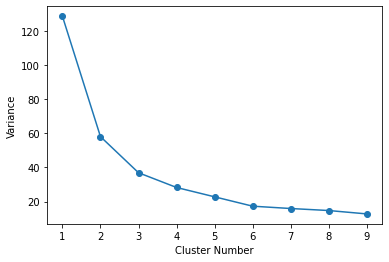

In [10]:
# These lines of code will plot the variance with respect to the cluster number.
variance = np.array(variance)
plt.scatter(variance[:,0], variance[:,1]) 
plt.plot(variance[:,0], variance[:,1]) 
plt.xlabel("Cluster Number")
plt.ylabel("Variance")
plt.show()

In [11]:
# By changing the number in the next line of code, we can see the centroids for the different cluster amounts.
print(Centroids_Per_Cluster[2])

[[6.81276596 3.07446809]
 [5.77358491 2.69245283]
 [5.00625    3.425     ]]


The next two cells will allow us to see the clusters for each of the cluster numbers. Change the N and rerun the cells to see the found clusters. 

In [12]:
N = 3

features = np.array(all_data.iloc[:,:F])
cluster_index = []

for d in features:
    centroids = Centroids_Per_Cluster[N - 1]

    D = [] 
    for s in range(N):
        D.append(d)

    distance = np.sqrt(np.sum(np.power(centroids - D, 2), axis = 1))

    cluster_index.append(np.argmin(distance))


clustered = np.array(list(zip(cluster_index, features)), dtype=object)

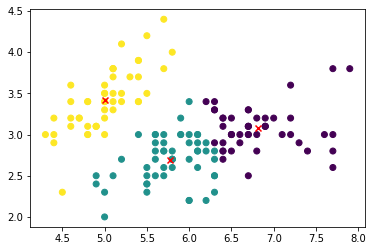

In [13]:
#info = pd.factorize(all_data.iloc[:,4])
plt.scatter(F1, F2, c = clustered[:,0])
plt.scatter(Centroids_Per_Cluster[N - 1][:,0], Centroids_Per_Cluster[N - 1][:,1], c = "red", marker='x')
plt.show()

900